**Implementing Customer Churn Prediction on the Telco dataset from Kaggle.**


**Step 1:** Importing necessary frameworks and modules for the project

In [ ]:
pip install tensorflow

In [ ]:
pip install focal-loss

In [ ]:
#importing the necessary libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
from sklearn import preprocessing
from focal_loss import BinaryFocalLoss

In [ ]:
#conncecting to my google drive for datasets
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Step 2:** Exploring the dataset

In [ ]:
#dataframe from the dataset in google drive
df=pd.read_csv('/content/gdrive/MyDrive/CustomerChurnPrediction/customerChurn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#for the description of data
df.info

<bound method DataFrame.info of       customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0     7590-VHVEG  Female              0  ...          29.85        29.85     No
1     5575-GNVDE    Male              0  ...          56.95       1889.5     No
2     3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3     7795-CFOCW    Male              0  ...          42.30      1840.75     No
4     9237-HQITU  Female              0  ...          70.70       151.65    Yes
...          ...     ...            ...  ...            ...          ...    ...
7038  6840-RESVB    Male              0  ...          84.80       1990.5     No
7039  2234-XADUH  Female              0  ...         103.20       7362.9     No
7040  4801-JZAZL  Female              0  ...          29.60       346.45     No
7041  8361-LTMKD    Male              1  ...          74.40        306.6    Yes
7042  3186-AJIEK    Male              0  ...         105.65       6844.5     No

[7043 r

In [ ]:
#no.of rows and columns in the dataframe
df.shape

(7043, 21)

In [ ]:
#dropped the customer id column since it is not needed
df.drop('customerID',axis='columns',inplace=True)



In [ ]:
df.shape

(7043, 20)

**Step 3:** Configure dataset according to the implementation and project

In [ ]:
#viewing the datatypes of all columns
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [ ]:
df.MonthlyCharges.values

array([ 29.85,  56.95,  53.85, ...,  29.6 ,  74.4 , 105.65])

In [ ]:
#pd.to_numeric(df.TotalCharges)
#we have spaces in the strings

In [ ]:
pd.to_numeric(df.TotalCharges,errors='coerce')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [ ]:
pd.to_numeric(df.TotalCharges,errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [ ]:
df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()]
# df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()].shape=(11,20)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [ ]:
#dropping the tuples which has total charges null value
#storing into a new dataframe
dfnew=df[df.TotalCharges!=' ']
dfnew.shape

(7032, 20)

In [ ]:
#now converting the totalcharges column object to number datatype
dfnew.TotalCharges = pd.to_numeric(dfnew.TotalCharges)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
dfnew.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [ ]:
#tenure is the no of months since the customer using the company services

churn_no=dfnew[dfnew.Churn=='No'].tenure
churn_yes=dfnew[dfnew.Churn=='Yes'].tenure
print(churn_no)

0        1
1       34
3       45
6       22
7       10
        ..
7037    72
7038    24
7039    72
7040    11
7042    66
Name: tenure, Length: 5163, dtype: int64


In [ ]:
print(churn_yes)

2        2
4        2
5        8
8       28
13      49
        ..
7021    12
7026     9
7032     1
7034    67
7041     4
Name: tenure, Length: 1869, dtype: int64


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


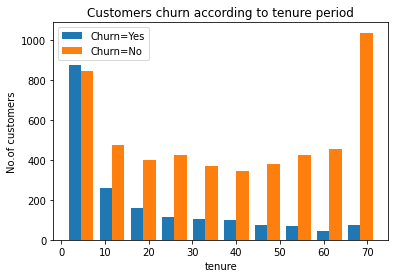

In [ ]:
#plotting the graph for visualizing
#customer churn according to tenure period
plt.xlabel("tenure")
plt.ylabel("No.of customers")
plt.title("Customers churn according to tenure period")
plt.hist([churn_yes,churn_no],label=['Churn=Yes','Churn=No'])
plt.legend()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


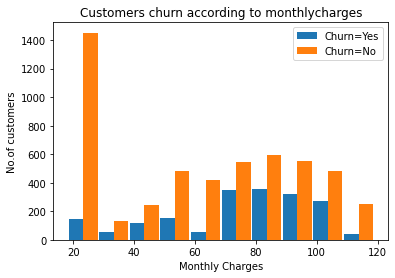

In [ ]:
#customer churn according to monthly rates
m_no=dfnew[dfnew.Churn=='No'].MonthlyCharges
m_yes=dfnew[dfnew.Churn=='Yes'].MonthlyCharges
plt.xlabel("Monthly Charges")
plt.ylabel("No.of customers")
plt.title("Customers churn according to monthlycharges")


plt.hist([m_yes,m_no],rwidth=0.95,label=['Churn=Yes','Churn=No'])
plt.legend()


**Step 4:** Data Cleaning

In [ ]:
def print_unique_column_values(dfnew):
    for column in dfnew:
       if dfnew[column].dtypes=='object':
           print(f'{column} : {dfnew[column].unique()}')

In [ ]:
print_unique_column_values(dfnew)

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [ ]:
#replacing the values in rows
dfnew.replace('No internet service','No',inplace=True)
dfnew.replace('No phone service','No',inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
print_unique_column_values(dfnew)


gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [ ]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    dfnew[col].replace({'Yes': 1,'No': 0},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
for col in dfnew:
    print(f'{col}: {dfnew[col].unique()}') 

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [ ]:
dfnew.dtypes

gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService      object
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [ ]:
dfnew['gender'].replace({'Female': 1,'Male': 0},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
dfnew['gender'].unique()

array([1, 0])

In [ ]:
#performing one hot encoding for remaining columns which has strings datatype
pd.get_dummies(data=dfnew,columns=['InternetService'])

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No
0,1,0,1,0,1,0,0,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0,1,0,0
1,0,0,0,0,34,1,0,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0,1,0,0
2,0,0,0,0,2,1,0,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,1,0,0
3,0,0,0,0,45,0,0,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,0,0
4,1,0,0,0,2,1,0,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,1,0,1,1,1,1,One year,1,Mailed check,84.80,1990.50,0,1,0,0
7039,1,0,1,1,72,1,1,0,1,1,0,1,1,One year,1,Credit card (automatic),103.20,7362.90,0,0,1,0
7040,1,0,1,1,11,0,0,1,0,0,0,0,0,Month-to-month,1,Electronic check,29.60,346.45,0,1,0,0
7041,0,1,1,0,4,1,1,0,0,0,0,0,0,Month-to-month,1,Mailed check,74.40,306.60,1,0,1,0


In [ ]:
df2=pd.get_dummies(data=dfnew,columns=['InternetService','Contract','PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
df2.shape

(7032, 27)

In [ ]:
#Remaining columns are Monthly charges,Total charges,tenure
#scaling the values using minmaxscaler. It will just scale the values to 0 to 1
scalingColumns=['tenure','MonthlyCharges','TotalCharges']
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df2[scalingColumns]=scaler.fit_transform(df2[scalingColumns])

In [ ]:
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,0.000000,0,0,0,1,0,0,0,0,1,0.115423,0.001275,0,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0.464789,1,0,1,0,1,0,0,0,0,0.385075,0.215867,0,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0.014085,1,0,1,1,0,0,0,0,1,0.354229,0.010310,1,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0.619718,0,0,1,0,1,1,0,0,0,0.239303,0.210241,0,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,0.014085,1,0,0,0,0,0,0,0,1,0.521891,0.015330,1,0,1,0,1,0,0,0,0,1,0


**Making x and y datasets**

In [ ]:
x=df2.drop('Churn',axis='columns')
y=df2['Churn']

In [ ]:
#we generally split data to training and testing dataset
#80% model training
#20% model fitting
#we can do that using train_test_split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=5)

In [ ]:
x_train.shape

(5625, 26)

In [ ]:
x_test.shape

(1407, 26)

**Step 6:** Building a neural network

**Implementing a Single layer feed forward network or Perceptron**

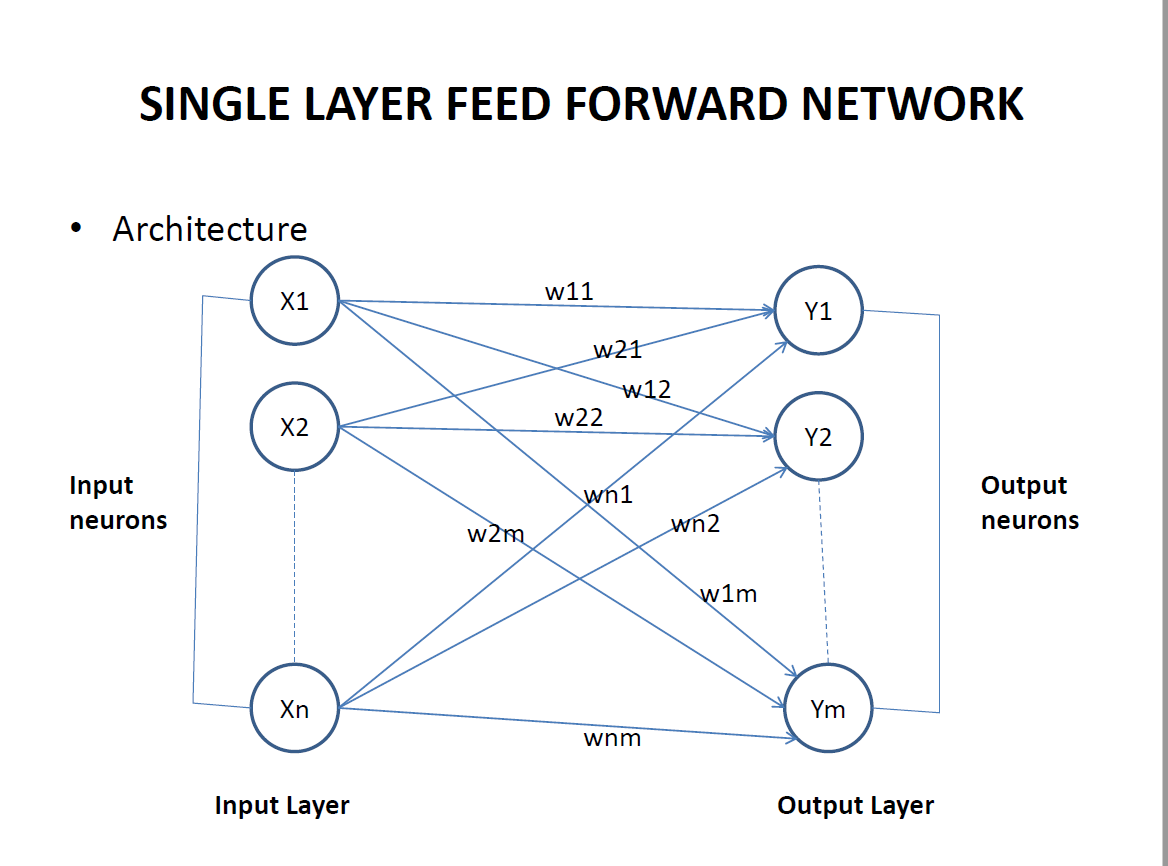

In [ ]:
#Basic artificial neural network without any hidden layers
#1 input layer and 1 output layer
model = keras.Sequential([
    # a fully conncected layer with inut shape 26 and 
    keras.layers.Dense(2,input_shape=(26,),activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)
model.fit(x_train,y_train,epochs=5,shuffle=True)

Epoch 1/5
176/176 [==============================] - 1s 1ms/step - loss: 0.5928 - accuracy: 0.6859
Epoch 2/5
176/176 [==============================] - 0s 2ms/step - loss: 0.4973 - accuracy: 0.7525
Epoch 3/5
176/176 [==============================] - 0s 1ms/step - loss: 0.4610 - accuracy: 0.7826
Epoch 4/5
176/176 [==============================] - 0s 1ms/step - loss: 0.4442 - accuracy: 0.7893
Epoch 5/5
176/176 [==============================] - 0s 1ms/step - loss: 0.4345 - accuracy: 0.7920


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 54        
                                                                 
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Basic artificial neural network without any hidden layers
#1 input layer and 1 output layer
model = keras.Sequential([
    # a fully conncected layer with inut shape 26 and 
    keras.layers.Dense(2,input_shape=(26,),activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)
model.fit(x_train,y_train,epochs=5)

Epoch 1/5
176/176 [==============================] - 1s 1ms/step - loss: 0.5887 - accuracy: 0.6880
Epoch 2/5
176/176 [==============================] - 0s 1ms/step - loss: 0.4882 - accuracy: 0.7600
Epoch 3/5
176/176 [==============================] - 0s 1ms/step - loss: 0.4562 - accuracy: 0.7838
Epoch 4/5
176/176 [==============================] - 0s 1ms/step - loss: 0.4408 - accuracy: 0.7868
Epoch 5/5
176/176 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7911


In [ ]:
weights, bias=model.get_weights()
weights, bias

(array([[-0.16985051, -0.33016434],
        [-0.15918559,  0.15249632],
        [-0.05818379, -0.02862082],
        [ 0.25473946, -0.11591774],
        [ 0.43026492, -0.5971641 ],
        [ 0.4589062 , -0.40054405],
        [-0.351759  , -0.42613104],
        [ 0.11938865, -0.24662754],
        [-0.0529219 , -0.41350174],
        [-0.26980254, -0.41499263],
        [ 0.15159597, -0.1023308 ],
        [-0.22791184,  0.16521233],
        [-0.0785169 , -0.2787427 ],
        [-0.2008832 ,  0.07339655],
        [-0.23238929, -0.10927645],
        [-0.15734376, -0.06778351],
        [-0.04026702, -0.37448698],
        [-0.38455874,  0.33506042],
        [-0.00389824, -0.45758647],
        [-0.5185318 ,  0.10852788],
        [ 0.38866428,  0.18928833],
        [ 0.39113122,  0.01649993],
        [ 0.2008709 , -0.30804244],
        [-0.09253337, -0.3066576 ],
        [-0.18809547,  0.06678596],
        [ 0.19724639, -0.15076527]], dtype=float32),
 array([ 0.11389067, -0.11389068], dtype=float3

In [ ]:
model.layers

In [ ]:
model.evaluate(x_test,y_test)

44/44 [==============================] - 0s 1ms/step - loss: 0.4525 - accuracy: 0.7846


[0.45250189304351807, 0.7846481800079346]

In [ ]:
predicted=model.predict(x_test)
predicted

array([[0.8315086 , 0.16849144],
       [0.71482474, 0.28517523],
       [0.9779181 , 0.0220819 ],
       ...,
       [0.33364975, 0.66635025],
       [0.42654085, 0.5734592 ],
       [0.78920394, 0.2107961 ]], dtype=float32)

In [ ]:
y_test

2660    0
744     0
5579    1
64      1
3287    1
       ..
2024    0
4396    1
4081    1
1297    0
4899    1
Name: Churn, Length: 1407, dtype: int64

**Neural Network 2**

With hidden layers

More the hidden layers, the efficiency of output response may increase

**Implementing Multi Layer Feedforward Neural Network with back propagation for adjusting weights or Multi layer perceptron network**

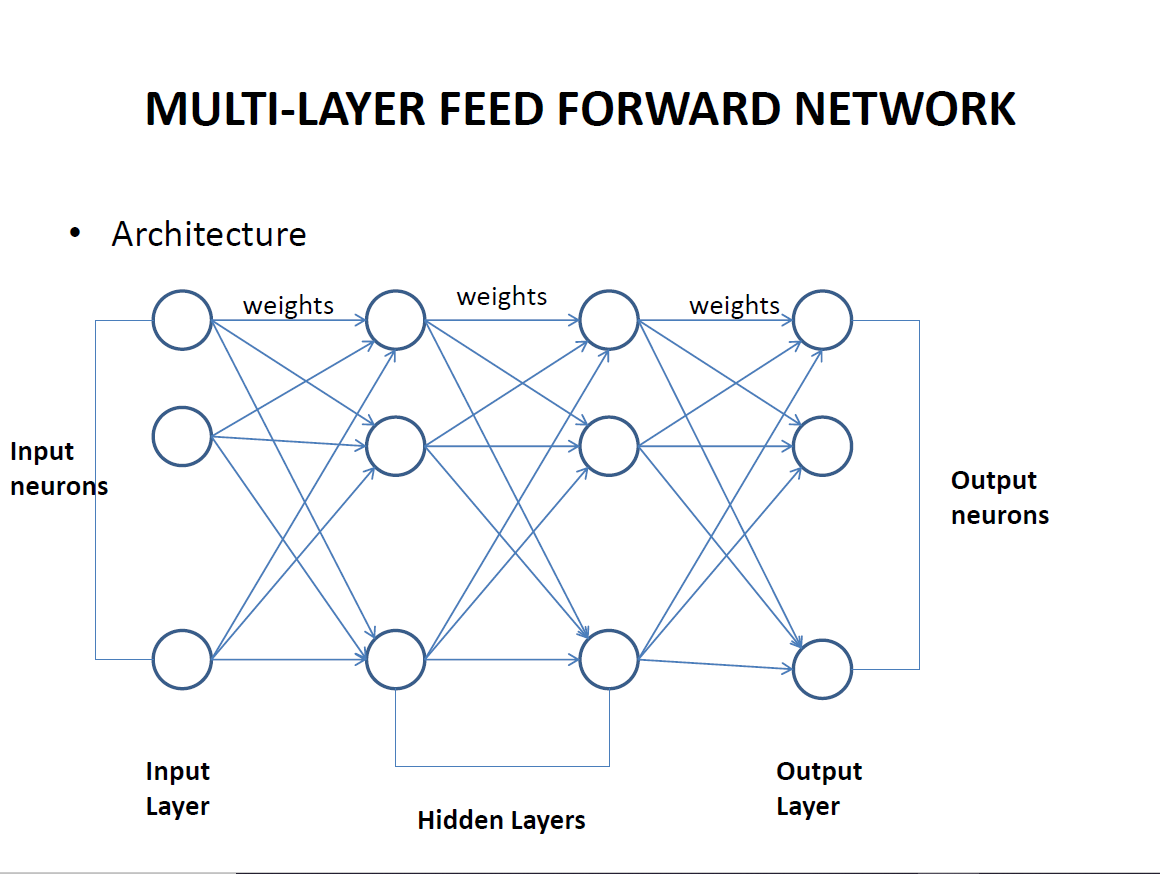

In [ ]:
#Basic artificial neural network with 2 hidden layer
#1 input layer,2 hidden layer, 1 output layer
model1 = keras.Sequential([
    keras.layers.Dense(20,input_shape=(26,),activation='relu'),
     keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid'),
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)
metrics=model1.fit(x_train,y_train,epochs=7,shuffle=True,batch_size=50)

Epoch 1/7
113/113 [==============================] - 1s 3ms/step - loss: 0.5163 - accuracy: 0.7463
Epoch 2/7
113/113 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.7886
Epoch 3/7
113/113 [==============================] - 0s 3ms/step - loss: 0.4232 - accuracy: 0.7948
Epoch 4/7
113/113 [==============================] - 0s 3ms/step - loss: 0.4194 - accuracy: 0.7977
Epoch 5/7
113/113 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.7998
Epoch 6/7
113/113 [==============================] - 0s 3ms/step - loss: 0.4134 - accuracy: 0.8028
Epoch 7/7
113/113 [==============================] - 0s 3ms/step - loss: 0.4129 - accuracy: 0.8016


In [ ]:
len(model1.layers)

3

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                540       
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 761
Trainable params: 761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
metrics2=model1.evaluate(x_test,y_test)
metrics2

44/44 [==============================] - 0s 5ms/step - loss: 0.4461 - accuracy: 0.7861


[0.44609424471855164, 0.7860696315765381]

In [ ]:
pred=model1.predict(x_test)
pred[:5]
#since it is in 2d array and with values from 0 to 1. Since our ground truth output is in either 0 or 1.
#We should round off these values to 0 and 1

array([[0.1278919 ],
       [0.36369604],
       [0.01435906],
       [0.7193784 ],
       [0.40531364]], dtype=float32)

In [ ]:
yPred=[]
for element in pred:
    if element > 0.5:
        yPred.append(1)
    else:
        yPred.append(0)

In [ ]:
y_test[:5]

2660    0
744     0
5579    1
64      1
3287    1
Name: Churn, dtype: int64

In [ ]:
yPred[:5]
# so we can see that predicted output is yPred and the ground truth is y_test.
#If we can see the first 5 values in both of them, we can see that we got only one customer value wrong. 
#It's a observation

[0, 0, 0, 1, 0]

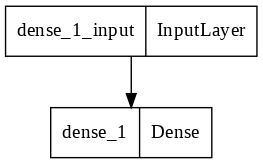

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', dpi=100)

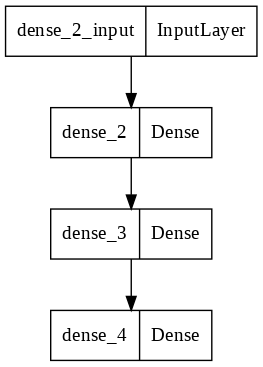

In [ ]:
tf.keras.utils.plot_model(model1, to_file='model1.png', dpi=100)

In [ ]:
#classification report

from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,yPred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       999
           1       0.67      0.53      0.60       408

    accuracy                           0.79      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.78      0.79      0.78      1407



Text(69.0, 0.5, 'Truth')

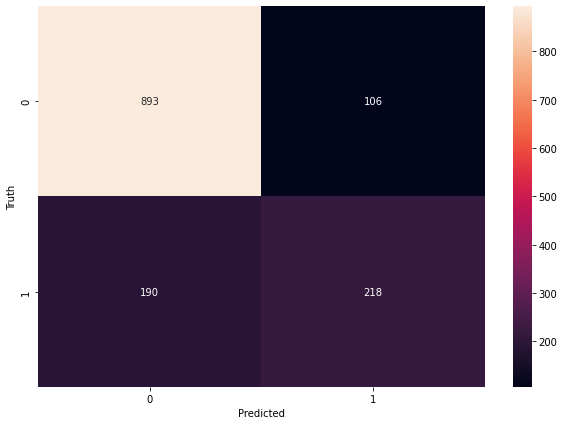

In [ ]:
# confusion matrix
import seaborn as sn
confusionmatrix = tf.math.confusion_matrix(labels=y_test,predictions=yPred)

plt.figure(figsize = (10,7))
sn.heatmap(confusionmatrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
#according to the confusion matrix, we made 190+106=296 errors and 893+218=1111 correct predictions 

In [ ]:
#accuracy is
round((893+218)/(190+106+893+218),2)

0.79

In [ ]:
#precision for 0 class
round(893/(893+190),2)

0.82

In [ ]:
#precision for 1 class
round(218/(218+106),2)

0.67

In [ ]:
#recall for 0 class
round(893/(893+106),2)

0.89

In [ ]:
#recall for 0 class
round(218/(218+190),2)

0.53